# Analyzing a synthetized fbm

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
figure_folder = 'figures/fBm/'

## Generating a signal

Let's first generate a brownian motion (fractional brownian motion with H=0.8)

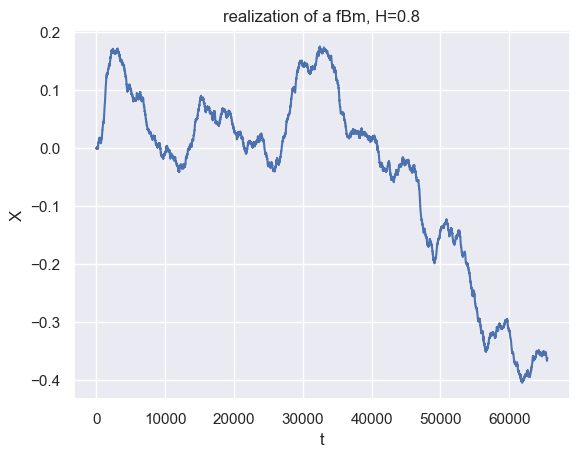

In [3]:
import sys
sys.path.append("../")
from pymultifracs.simul import fbm

X = fbm(shape=65536, H=0.8)

plt.plot(X)
plt.title('realization of a fBm, H=0.8')
plt.ylabel('X')
plt.xlabel('t')
plt.show()

## Power Spectral Density

Power spectral density analysis is done with the `psd` module

The sampling frequency `fs` is necessary in order to correctly label the frequency axis

In [4]:
import pymultifracs.psd as psd

fs  = 1

The Fourier-based PSD estimation is done using the Welch estimator.

The arguments relative the Fourier-based estimation are:
* `n_fft`: length of the FFT used
* `seg_size`: size of the segment used in the Welch estimation

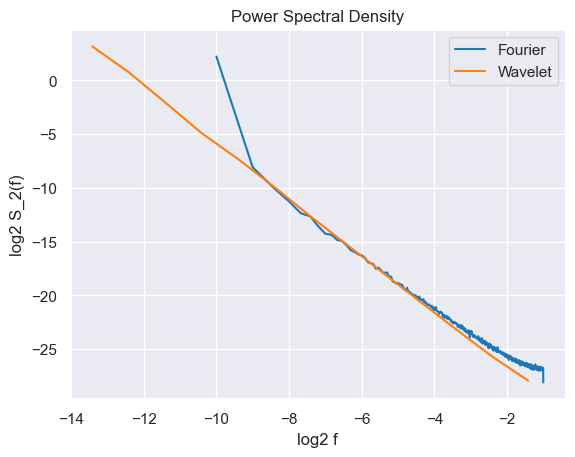

In [5]:
psd.plot_psd(X, fs, n_fft=1024)

The Wavelet-based estimation is done using wavelet analysis based on the Daubechies wavelet.

The number of vanishing moments can be controlled using the `n_moments` argument

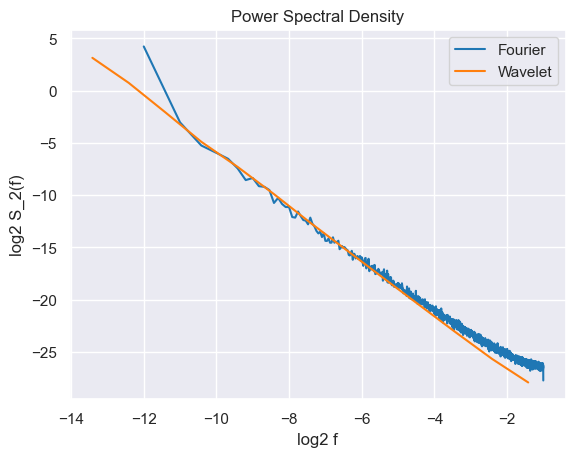

In [6]:
psd.plot_psd(X, fs, n_moments=2)

The wavelet-based estimation of the PSD is obtained via the `wavelet_estimation` function

In [7]:
PSD = psd.wavelet_estimation(X, fs, n_moments=3)

The output is an instance of the `PSD` namedtuple, with two fields: `freq` which contains the frequency support of the PSD estimation, and `psd` which contains the actual power estimates

In [8]:
PSD.freq, PSD.psd

(array([3.75000000e-01, 1.87500000e-01, 9.37500000e-02, 4.68750000e-02,
        2.34375000e-02, 1.17187500e-02, 5.85937500e-03, 2.92968750e-03,
        1.46484375e-03, 7.32421875e-04, 3.66210938e-04, 1.83105469e-04,
        9.15527344e-05]),
 array([[3.36104487e-09],
        [1.59889946e-08],
        [9.55178869e-08],
        [5.89423628e-07],
        [3.49039015e-06],
        [2.09599314e-05],
        [1.35187338e-04],
        [8.84184250e-04],
        [5.16960908e-03],
        [2.82785108e-02],
        [2.29708970e-01],
        [9.03908633e-01],
        [2.81908316e+00]]))

## Wavelet Transform

Wavelet transform is performed in the package using the `wavelet` submodule

In [9]:
from pymultifracs.wavelet import wavelet_analysis

The wavelet analysis computes the wavelet coefficients and wavelet leaders (if specified) for a particular signal.

The output is a namedtuple with 3 fields:

* `wt_leaders`: The wavelet leaders if computed
* `wt_coefs`: Wavelet coefficients
* `j2_eff`: Maximum scale that the coefficients were effectively computed for

In [10]:
Y = fbm(shape=100, H=0.8)

In [11]:
WT = wavelet_analysis(Y)

/Users/gsaes/Projets/pymultifracs/examples/../pymultifracs/wavelet.py:130: UserWarning: Value of j2 is higher than the maximum allowed level. Max level and j2 set to 3
  warnings.warn(


The `j2` parameter controls the maximum scale at with the wavelet coefs and leaders will be computed

In [12]:
WT = wavelet_analysis(Y, j2=2)

The `p_exp` parameter controls how wavelet leaders are computed: if set to an int, wavelet p-leaders will be computed, if set to `np.inf`, it will use the wavelet leaders. If it is left to None, only the wavelet coefs will be computed

In [13]:
WT = wavelet_analysis(Y, p_exp=None)

In [14]:
WT = wavelet_analysis(Y, p_exp=2)

## Second order analysis

In [15]:
import pymultifracs.mfa as mfa
from pymultifracs.utils import build_q_log
from pymultifracs.wavelet import wavelet_analysis
import numpy as np

Basic parameters are:

`j1` and `j2`, which indicate respectively the minimum and the maximum scale to consider when fitting wavelet coefficients

`q` The values of q for which the wavelet coefficients will be estimated

`n_cumul` The maximum order of the cumulants to compute

The p_exponent parameters `p_exp` controls how wavelet leaders are used: if set to an int, it will use wavelet p-leaders, or if set to `np.inf`, it will use the wavelet leaders.

The output of the `mf_analysis_full` function contains two variables, `dwt` and `lwt`. The former contains the multifractal variables computed using the wavelet coefs, while the latter uses the wavelet leaders.

By default the `p_exp` parameter is set to `None`, which means the wavelet coefs only are used, and so the `lwt` variable returned is set to `None`

In [40]:
dwt, lwt = mfa.mf_analysis_full(X,
    scaling_ranges =[[2,8]],
    p_exp=np.inf,
    q=np.array([2]),
    n_cumul=2,
)

In [17]:
print(lwt.structure)

StructureFunction(weights=array([[[[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]]]]), formalism='wavelet leader', gamint=0.0, wt_name=None, nj={1: array([32764]), 2: array([16379]), 3: array([8186]), 4: array([4090]), 5: array([2042]), 6: array([1018]), 7: array([506]), 8: array([250])}, n_sig=1, bootstrapped_mrq=None, q=array([2]), scaling_ranges=array([[2, 8]]), weighted=None, j=array([1, 2, 3, 4, 5, 6, 7, 8]), logvalues=array([[[-28.09362658],
        [-26.65603421],
        [-25.14497527],
        [-23.54159204],
        [-21.96066642],
        [-20.37392122],
        [-18.72451856],
        [-17.14618514]]]), zeta=array([[[1.59064755]]]), H=array([[0.79532378]]))


**Unpacking dwt**

The variable dwt contains three fields: the structure functions, cumulants, multifractal spectrum, and hmin estimate. They can be unpacked all at once, or called one by one

In [31]:
sf, cumul, mfs, hmin = dwt

In [19]:
sf = dwt.structure
hmin = dwt.hmin

**H estimate**

In [20]:
sf.H

array([[0.80983802]])

**structure functions**

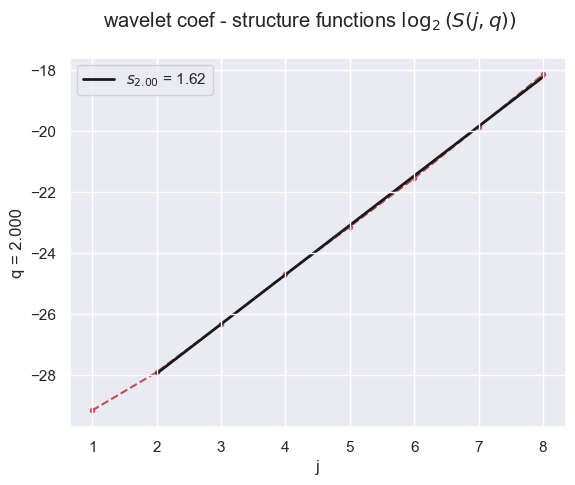

In [21]:
sf.plot(nrow=5)

## Multifractal Analysis

### Using wavelet leaders

In [24]:
dwt, lwt = mfa.mf_analysis_full(X,
    scaling_ranges=[[3,12]],
    q=build_q_log(1, 10, 20),
    n_cumul=2,
    p_exp=np.inf,
    gamint=0.0
)

The `lwt` variable shares the same structure as `dwt`

In [25]:
lwt_sf, lwt_cumul, lwt_mfs, hmin = lwt

The `lwt_sf`, `lwt_cumul`, `lwt_mfs` variables defined here share the same structure as the `sf`, `cumul`, and `mfs` variables defined previously

**structure functions**

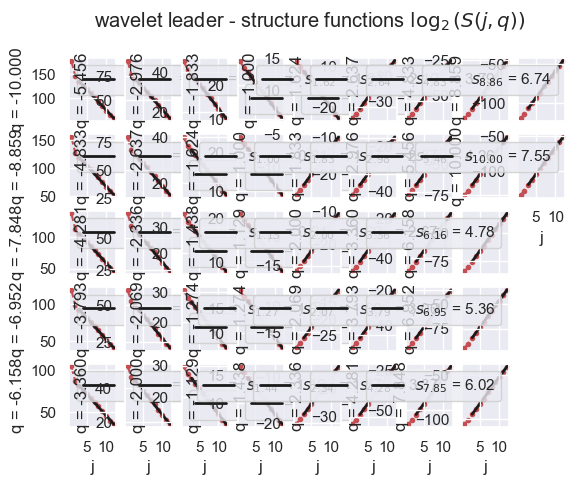

In [26]:
lwt_sf.plot(nrow=5)

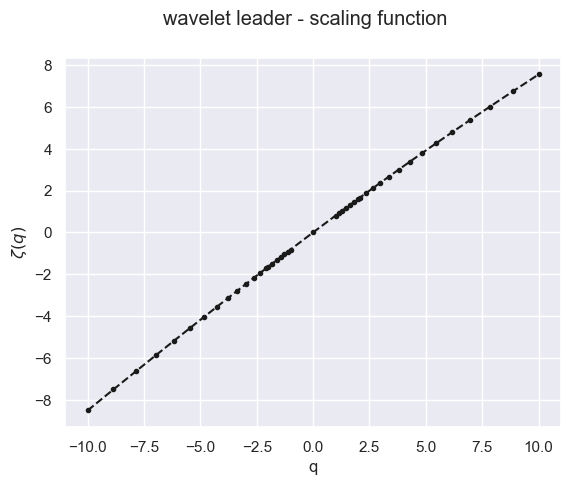

In [27]:
lwt_sf.plot_scaling()

**cumulants**

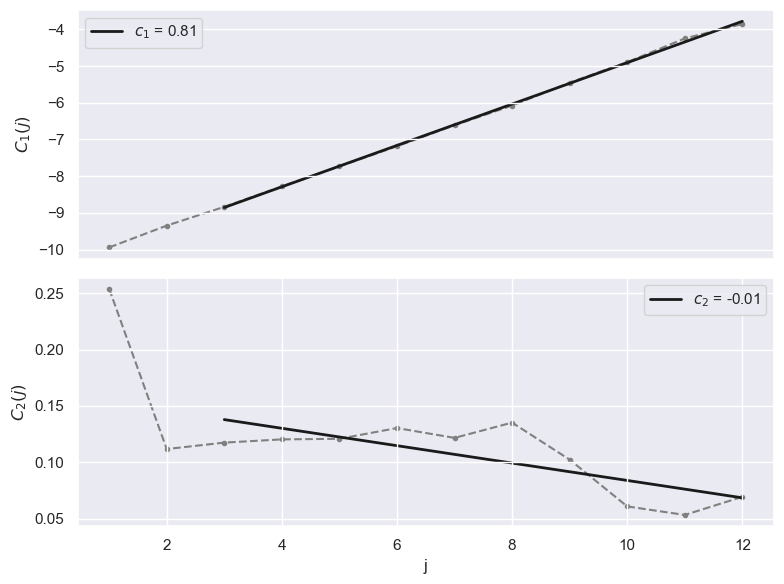

In [28]:
lwt_cumul.plot(nrow=2)

In [29]:
lwt_cumul.log_cumulants

array([[[ 0.81336625]],

       [[-0.01112542]]])

**multifractal spectrum**

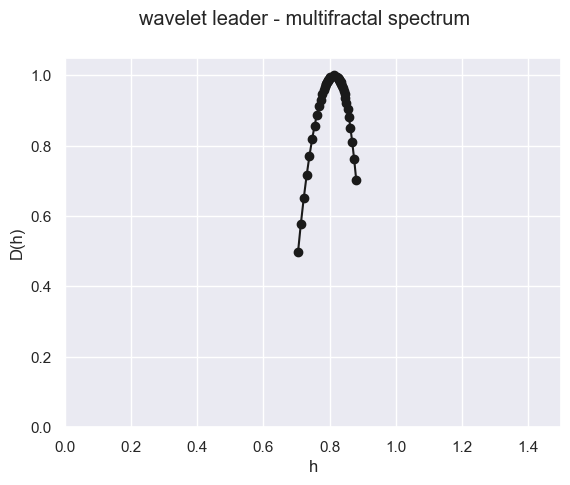

In [30]:
lwt_mfs.plot()

### Using p-leaders

In [33]:
dwt, lwt = mfa.mf_analysis_full(X,
    scaling_ranges=[[2,8]],
    q=build_q_log(1, 10, 20),
    n_cumul=2,
    p_exp=2
)

The `lwt` variable shares the same structure as `dwt`

In [34]:
lwt_sf, lwt_cumul, lwt_mfs, hmin = lwt

The `lwt_sf`, `lwt_cumul`, `lwt_mfs` variables defined here share the same structure as the `sf`, `cumul`, and `mfs` variables defined previously

**structure functions**

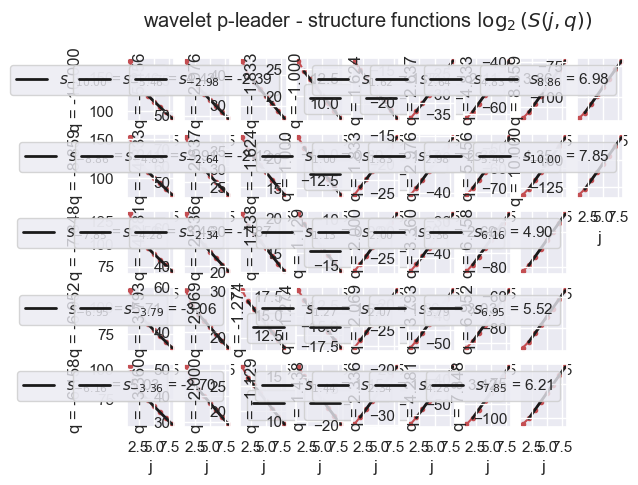

In [35]:
lwt_sf.plot(nrow=5)

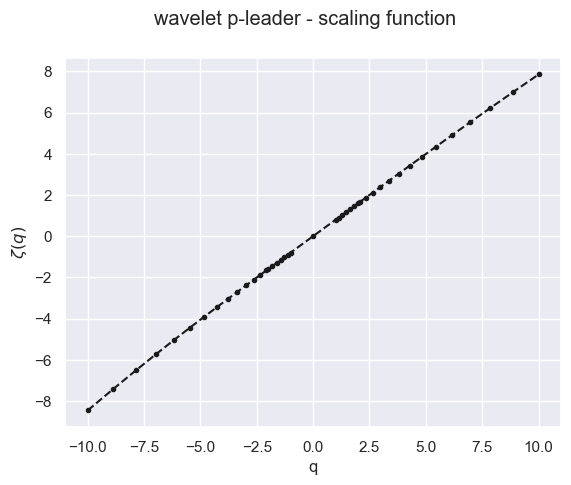

In [36]:
lwt_sf.plot_scaling()

**cumulants**

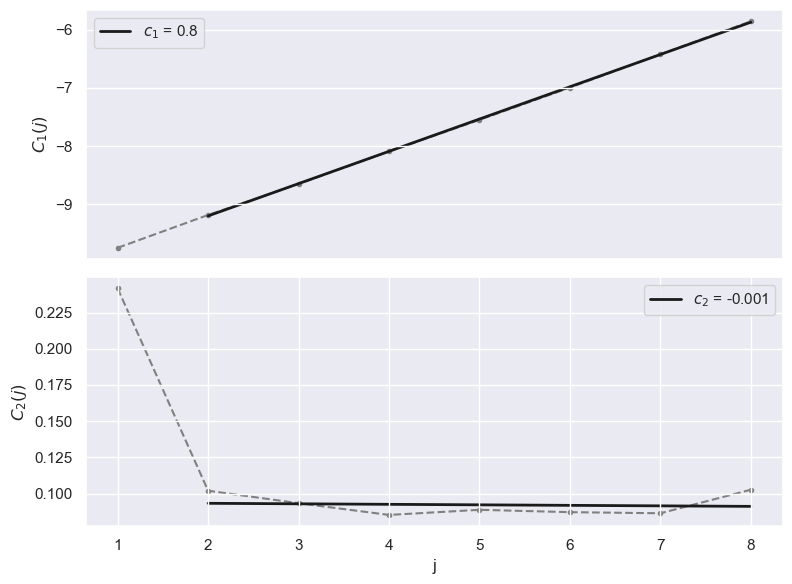

In [37]:
lwt_cumul.plot(nrow=3)

In [38]:
lwt_cumul.log_cumulants

array([[[ 8.00222957e-01]],

       [[-5.09828422e-04]]])

**multifractal spectrum**

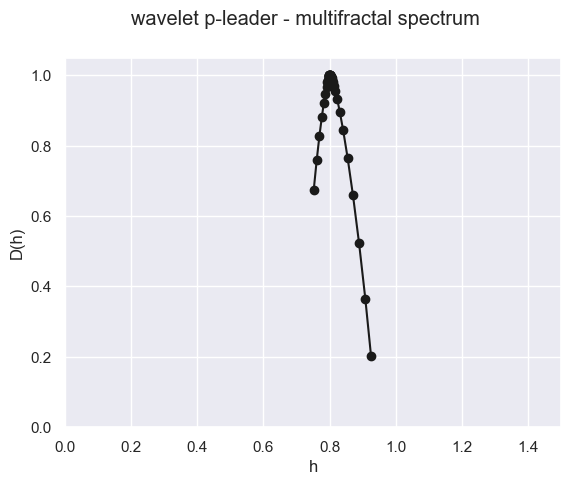

In [39]:
lwt_mfs.plot()